# **Churn Analysis in Beta Bank**

#Project Goals

There are many customers of Bank Beta has left the company: slowly, their number has been decreased in each month. Bank employees has realized that it was cheaper to retain their loyal old customers than to attract a new ones.

In this case, our task is to predict whether a customer will leave the bank soon or not. We have data regarding the past behavior of customer and their history of termination of contracts with the bank.

Build a model with the highest possible F1 score. In order to pass the review, you need a minimum F1 score of 0.59 for the test dataset. Check the F1 value for the test set.

In addition, measure the AUC-ROC metric and compare it to the F1 score.

#Instructions

1. Download and prepare the data. Describe the procedure.
2. Check the balance of existing classes. Train your model without considering the imbalance. Describe in brief your discovery.
3. Improve the quality of the model. Make sure that you use at least two approaches to correct imbalance class . Use the training set to choose the best parameters. Train different models in the training and validation sets. Find the best model. Describe in brief your discovery.
4. Run the final test.

# Data Description
The data you need can be found in the file `/content/Churn.csv`. Download datasets.

**Features**

- `RowNumber` — string data index
- `CustomerId` — customer unique ID
- `Surname` — last name
- `CreditScore` — customer credit score
- `Geography` — customer country domocile
- `Gender` — customer gender
- `Age` — customer age
- `Tenure` — maturity period for fixed deposits customer (in years)
- `Balance` — customer balance account
- `NumOfProducts` — total of bank products that has been used by customers
- `HasCrCard` — do customers owned a credit card?
- `IsActiveMember` — is customer still active?
- `EstimatedSalary` — customer estimated salary

**Target**

- `Exited` — does customer already stopped subscribing?

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.stats as stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle

#for importing files to google collab
#from google.colab import files

In [ ]:
#upload datasets
#uploaded = files.upload()

#1. Download and prepare the data. Describe the procedure.

In [ ]:
df_churn = pd.read_csv('/content/Churn.csv')

In [ ]:
df_churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


# Sanity Check target variables/features

Goals: predict whether a customer will leave the bank soon or not. We have data regarding the past behavior of clients and their history of termination of contracts with the bank.

In [ ]:
df_churn['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [ ]:
# imbalance dataset -> not a good model -> bad accuracy
# do the upsample and downsample
df_churn['Exited'].value_counts() / df_churn.shape[0] * 100

0    79.63
1    20.37
Name: Exited, dtype: float64

**Conclusion**

Data is dominated by feature data at **79.63%**. It results in imbalance dataset, and poor accuracy. As a solution, we need to do an upsample and downsample tests.

In [ ]:
df_churn.shape

(10000, 14)

In [ ]:
df_churn.isnull().sum()

RowNumber            0
CustomerId           0
Surname              0
CreditScore          0
Geography            0
Gender               0
Age                  0
Tenure             909
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
dtype: int64

In [ ]:
df_churn.isnull().sum() / df_churn.shape[0] * 100

RowNumber          0.00
CustomerId         0.00
Surname            0.00
CreditScore        0.00
Geography          0.00
Gender             0.00
Age                0.00
Tenure             9.09
Balance            0.00
NumOfProducts      0.00
HasCrCard          0.00
IsActiveMember     0.00
EstimatedSalary    0.00
Exited             0.00
dtype: float64

There is 9% of missing values, which can be filled using the median value

In [ ]:
df_churn.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


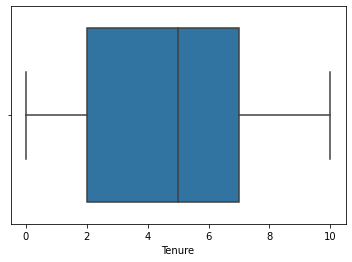

In [ ]:
sns.boxplot(df_churn['Tenure']); #check outliers in Tenure column

There is no outliers, but there is some missing values, we can fill in using the median value (5)

In [ ]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [ ]:
df_churn.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure             float64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

**Conclusion**

The `Churn.csv` dataset contains 10,000 rows and 15 columns of data. However, there is a missing value of 9% in the `Tenure` column. In order to create a good model quality, we must fill the missing values, in this case we can use the median value.

# 2. Check the balancing of the existing classes. Train your model without considering the imbalance. Describe in brief your discovery.

In [ ]:
df_churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [ ]:
drop_cols = ['RowNumber', 'CustomerId', 'Surname']

numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance',
                'NumOfProducts', 'HasCrCard', 'IsActiveMember',
                'EstimatedSalary']

categorical_cols = ['Geography', 'Gender']

**Conclusion**

To make it easier when testing the model, we seperate some columns based on their type:
- `drop_cols` = we will drop this column. we will not use this one
- `numeric_cols` = the column contains numeric data
- `categorical_cols` = the column contains categorical data

**Drop the unused columns**

In [ ]:
df_churn = df_churn.drop(columns = drop_cols)

In [ ]:
df_churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


**Conclusion**

We have dropped the unused columns. The data looks already cleaned

**Encoding variable features**

In [ ]:
df_churn = pd.get_dummies(df_churn, columns=categorical_cols)

In [ ]:
df_churn.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,0,1,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,1,0,0,1,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,1,0,0,1,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,0,1,1,0


**Conclusion**

After we dropped the unused columns, we also need to separate the categorical and numeric columns. Next, we encode the features variable for categorical columns to convert the categorical features into numeric features.

**Filling missing values**

In [ ]:
df_churn['Tenure'] = df_churn['Tenure'].fillna(value=df_churn['Tenure'].median())

In [ ]:
# Check data that already been filled
df_churn.isnull().sum()

CreditScore          0
Age                  0
Tenure               0
Balance              0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary      0
Exited               0
Geography_France     0
Geography_Germany    0
Geography_Spain      0
Gender_Female        0
Gender_Male          0
dtype: int64

In [ ]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_France   10000 non-null  uint8  
 10  Geography_Germany  10000 non-null  uint8  
 11  Geography_Spain    10000 non-null  uint8  
 12  Gender_Female      10000 non-null  uint8  
 13  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(5)
memory usage: 752.1 KB


**Conclusion**

Missing values already been filled using the median value of the column. And there is no missing values anymore. We are ready train data.

# 3. Check the balancing of the existing classes. Train your model without considering the imbalance. Describe in brief your discovery.

In [ ]:
df_churn['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [ ]:
df_churn['Exited'].value_counts() / df_churn.shape[0] * 100

0    79.63
1    20.37
Name: Exited, dtype: float64

**Separate the dat source into training sets, validation sets, and test sets.**

In [ ]:
train_valid, test = train_test_split(df_churn, random_state=2023, test_size=0.15)
train, valid = train_test_split(train_valid, random_state=2023, test_size=0.15)

#train
features_train = train.drop(['Exited'], axis=1)
target_train = train['Exited']

#validation
features_valid = valid.drop(['Exited'], axis=1)
target_valid = valid['Exited']

#test
features_test = test.drop(['Exited'], axis=1)
target_test = test['Exited']

print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(7225, 13)
(1275, 13)
(1500, 13)


In [ ]:
numeric_cols

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary']

In [ ]:
#scaling features
scaler = StandardScaler()

features_train[numeric_cols] = scaler.fit_transform(features_train[numeric_cols])#fit_transform hanya di features_train

features_valid[numeric_cols] = scaler.transform(features_valid[numeric_cols])
features_test[numeric_cols] = scaler.transform(features_test[numeric_cols])

In [ ]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
3196,-0.405038,-0.266889,-0.353231,0.853691,0.796621,0.645067,-1.030500,0.054438,1,0,0,0,1
3200,-0.150095,-1.419014,-0.353231,1.025878,-0.924032,0.645067,0.970403,0.755763,0,0,1,0,1
6860,0.788096,0.597205,0.373241,0.613304,0.796621,0.645067,0.970403,0.089949,0,1,0,0,1
3658,0.502560,0.405184,-0.716468,0.074521,-0.924032,0.645067,-1.030500,1.738075,1,0,0,1,0
5702,-0.659981,-0.266889,0.736477,-1.218283,0.796621,0.645067,-1.030500,-0.090975,1,0,0,0,1


In [ ]:
#Logistic Regression
model = LogisticRegression(random_state=2023)

model.fit(features_train, target_train)
predicted_train = model.predict(features_train)
predicted_valid = model.predict(features_valid)


print('F1 train = ', f1_score(target_train, predicted_train))
print('AUC-ROC train = ', roc_auc_score(target_train, predicted_train))
print('F1 = ', f1_score(target_valid, predicted_valid))
print('AUC-ROC = ', roc_auc_score(target_valid, predicted_valid))

F1 train =  0.28482328482328484
AUC-ROC train =  0.5771852218063483
F1 =  0.3513513513513513
AUC-ROC =  0.6030346460618146


**Conclusion**

By using **Logistic Regression** we have F1 score at 0.31 for train dataset and 0.32 for valid dataset

In [ ]:
#Random Forest Classifier
for estim in range(10, 101, 10):
    model = RandomForestClassifier(random_state=2023, n_estimators=estim)

    model.fit(features_train, target_train)
    predicted_train = model.predict(features_train)
    probabilities_train = model.predict_proba(features_train)[:, 1]
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)[:, 1]

    print("n_estimators = ", estim)
    print('  F1 train= ', f1_score(target_train, predicted_train))
    print('  AUC-ROC train= ', roc_auc_score(target_train, probabilities_train))
    print('  F1 = ', f1_score(target_valid, predicted_valid))
    print('  AUC-ROC = ', roc_auc_score(target_valid, probabilities_valid))

n_estimators =  10
  F1 train=  0.9595417114214106
  AUC-ROC train=  0.9996503969766799
  F1 =  0.5400457665903892
  AUC-ROC =  0.812780408773679
n_estimators =  20
  F1 train=  0.9856693463823838
  AUC-ROC train=  0.9999949272350663
  F1 =  0.5707762557077626
  AUC-ROC =  0.8235807284030262
n_estimators =  30
  F1 train=  0.994107452339688
  AUC-ROC train=  0.999999462883713
  F1 =  0.5793103448275861
  AUC-ROC =  0.8341611195824292
n_estimators =  40
  F1 train=  0.995847750865052
  AUC-ROC train=  1.0
  F1 =  0.5720823798627003
  AUC-ROC =  0.8365491760014075
n_estimators =  50
  F1 train=  0.9996552912788693
  AUC-ROC train=  1.0
  F1 =  0.560919540229885
  AUC-ROC =  0.8375608468711513
n_estimators =  60
  F1 train=  0.9996552912788693
  AUC-ROC train=  1.0
  F1 =  0.5610859728506787
  AUC-ROC =  0.8395053809160753
n_estimators =  70
  F1 train=  0.9993103448275862
  AUC-ROC train=  1.0
  F1 =  0.5603644646924829
  AUC-ROC =  0.8420235616679375
n_estimators =  80
  F1 train=  0.99

**Conclusion**

By using **Random Forest Classifier** with `n_estimators` 100 we have F1 score at 0.59. We still have a big gap, overfitting data still occurs.

In [ ]:
#Decision Tree Classifier
for depth in [1, 2, 4, 6, 8, None]:
    model = DecisionTreeClassifier(random_state=2023, max_depth=depth)

    model.fit(features_train, target_train)
    predicted_train = model.predict(features_train)
    probabilities_train = model.predict_proba(features_train)[:, 1]
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)[:, 1]

    print("max_depth = ", depth)
    print('  F1 train= ', f1_score(target_train, predicted_train))
    print('  AUC-ROC train= ', roc_auc_score(target_train, probabilities_train))
    print('  F1 = ', f1_score(target_valid, predicted_valid))
    print('  AUC-ROC = ', roc_auc_score(target_valid, probabilities_valid))

max_depth =  1
  F1 train=  0.0
  AUC-ROC train=  0.6718813894458322
  F1 =  0.0
  AUC-ROC =  0.6772806580259222
max_depth =  2
  F1 train=  0.5015398152221734
  AUC-ROC train=  0.726248419386126
  F1 =  0.5275229357798165
  AUC-ROC =  0.7300341622192248
max_depth =  4
  F1 train=  0.5051837888784165
  AUC-ROC train=  0.8238204269859636
  F1 =  0.5190839694656489
  AUC-ROC =  0.803306990792329
max_depth =  6
  F1 train=  0.5828970331588132
  AUC-ROC train=  0.8691817474994848
  F1 =  0.5509259259259259
  AUC-ROC =  0.8178497595448947
max_depth =  8
  F1 train=  0.6554690700532568
  AUC-ROC train=  0.8986921695845608
  F1 =  0.5486725663716815
  AUC-ROC =  0.7999255908744356
max_depth =  None
  F1 train=  1.0
  AUC-ROC train=  1.0
  F1 =  0.4955436720142602
  AUC-ROC =  0.6807390329012961


**Conclusion**

By using **Decision Tree Classifier** with `max_depth` 6, we have F1 score at 0.60. We still have a big gap, overfitting data still occurs.

#4. Improve model quality

- Ensure that we've used at least two approaches to correct class imbalance. Use the training set to choose the best parameters. Train different models in the training and validation sets. Find the best model. Describe in brief your discovery.

**class_weight adjustment**

In [ ]:
#Logistic Regression
model = LogisticRegression(random_state=2023, class_weight='balanced')

model.fit(features_train, target_train)
predicted_train = model.predict(features_train)
predicted_valid = model.predict(features_valid)


print('F1 train = ', f1_score(target_train, predicted_train))
print('AUC-ROC train = ', roc_auc_score(target_train, predicted_train))
print('F1 = ', f1_score(target_valid, predicted_valid))
print('AUC-ROC = ', roc_auc_score(target_valid, predicted_valid))

F1 train =  0.48661800486618
AUC-ROC train =  0.7009286979322454
F1 =  0.5122897800776197
AUC-ROC =  0.7129237288135594


**Conclusion**

There was an increase after adjustments to the F1 score in train set by 19% (before: 0.30, and after 0.49). And then, F1 score in valid set at 19% (before: 0.31, and after 0.50)

In [ ]:
#Random Forest Classifier
for estim in range(10, 101, 10):
    model = RandomForestClassifier(random_state=2023, n_estimators=estim, class_weight='balanced')

    model.fit(features_train, target_train)
    predicted_train = model.predict(features_train)
    probabilities_train = model.predict_proba(features_train)[:, 1]
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)[:, 1]

    print("n_estimators = ", estim)
    print('  F1 train= ', f1_score(target_train, predicted_train))
    print('  AUC-ROC train= ', roc_auc_score(target_train, probabilities_train))
    print('  F1 = ', f1_score(target_valid, predicted_valid))
    print('  AUC-ROC = ', roc_auc_score(target_valid, probabilities_valid))

n_estimators =  10
  F1 train=  0.9606299212598426
  AUC-ROC train=  0.999619303911615
  F1 =  0.5181598062953995
  AUC-ROC =  0.8137774177467597
n_estimators =  20
  F1 train=  0.9884977344022308
  AUC-ROC train=  0.9999773217567666
  F1 =  0.5648148148148148
  AUC-ROC =  0.8329900005864759
n_estimators =  30
  F1 train=  0.9934096427332639
  AUC-ROC train=  0.9999974337777394
  F1 =  0.5581395348837209
  AUC-ROC =  0.8412116591402263
n_estimators =  40
  F1 train=  0.9975820379965458
  AUC-ROC train=  0.9999999403204125
  F1 =  0.5720823798627003
  AUC-ROC =  0.8448826315172131
n_estimators =  50
  F1 train=  0.9986197377501725
  AUC-ROC train=  0.9999999999999999
  F1 =  0.5471264367816092
  AUC-ROC =  0.8446223828514456
n_estimators =  60
  F1 train=  0.9993103448275862
  AUC-ROC train=  1.0
  F1 =  0.5509259259259259
  AUC-ROC =  0.8448716350947159
n_estimators =  70
  F1 train=  1.0
  AUC-ROC train=  1.0
  F1 =  0.5361305361305361
  AUC-ROC =  0.8420473872500147
n_estimators =  8

In [ ]:
#Decision Tree Classifier
for depth in [1, 2, 4, 6, 8, None]:
    model = DecisionTreeClassifier(random_state=2023, max_depth=depth, class_weight='balanced')

    model.fit(features_train, target_train)
    predicted_train = model.predict(features_train)
    probabilities_train = model.predict_proba(features_train)[:, 1]
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)[:, 1]

    print("max_depth = ", depth)
    print('  F1 train= ', f1_score(target_train, predicted_train))
    print('  AUC-ROC train= ', roc_auc_score(target_train, probabilities_train))
    print('  F1 = ', f1_score(target_valid, predicted_valid))
    print('  AUC-ROC = ', roc_auc_score(target_valid, probabilities_valid))

max_depth =  1
  F1 train=  0.4798711755233494
  AUC-ROC train=  0.6884755971360482
  F1 =  0.4863309352517986
  AUC-ROC =  0.6840416251246262
max_depth =  2
  F1 train=  0.5093847758081335
  AUC-ROC train=  0.7429183604728247
  F1 =  0.5098039215686274
  AUC-ROC =  0.7358842589877425
max_depth =  4
  F1 train=  0.5374600835175632
  AUC-ROC train=  0.8221056533995761
  F1 =  0.5184210526315789
  AUC-ROC =  0.8032080229898539
max_depth =  6
  F1 train=  0.5951270088128564
  AUC-ROC train=  0.8695699632158895
  F1 =  0.5327868852459016
  AUC-ROC =  0.8172394580962994
max_depth =  8
  F1 train=  0.6569468267581475
  AUC-ROC train=  0.9025690152653223
  F1 =  0.5880551301684532
  AUC-ROC =  0.8097728872206909
max_depth =  None
  F1 train=  1.0
  AUC-ROC train=  1.0
  F1 =  0.48659003831417624
  AUC-ROC =  0.6721398305084745


**Conclusion**

The highest F1 score in train set were at `max_depth` 6 which is 0.59

**upsampling**

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=2023)

    return features_upsampled, target_upsampled

In [ ]:
# we performed downsample and upsample to train set based on our objective
# we can't use fractions for repeated variables
features_upsampled, target_upsampled = upsample(features_train, target_train, 3) #3 means we performed upsampled 3 times (3x)

In [ ]:
#1 is a minority class
target_train.value_counts()

0    5774
1    1451
Name: Exited, dtype: int64

In [ ]:
# minority class is upsampled until it approaches the majority class (should not be exceeded the majority class)
target_upsampled.value_counts()

0    5774
1    4353
Name: Exited, dtype: int64

In [ ]:
#check the upsample result
1456 * 3

4368

**Conclusion**

Upsample is used to make the value of the minority class (maximized) can be close to the majority class

In [ ]:
#Logistic Regression
model = LogisticRegression(random_state=2023)

model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

print('F1 = ', f1_score(target_valid, predicted_valid))
print('AUC-ROC = ', roc_auc_score(target_valid, probabilities_valid))

F1 =  0.5150602409638555
AUC-ROC =  0.7763437628291596


In [ ]:
#Random Forest Classifier
for estim in range(10, 101, 10):
    model = RandomForestClassifier(random_state=2023, n_estimators=estim)

    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)[:, 1]

    print("n_estimators = ", estim)
    print('  F1 = ', f1_score(target_valid, predicted_valid))
    print('  AUC-ROC = ', roc_auc_score(target_valid, probabilities_valid))

n_estimators =  10
  F1 =  0.5477178423236514
  AUC-ROC =  0.801668523840244
n_estimators =  20
  F1 =  0.5551020408163265
  AUC-ROC =  0.814330904345786
n_estimators =  30
  F1 =  0.5720081135902636
  AUC-ROC =  0.8251587150313765
n_estimators =  40
  F1 =  0.5813008130081301
  AUC-ROC =  0.8311022813911207
n_estimators =  50
  F1 =  0.5875251509054324
  AUC-ROC =  0.8315916221922468
n_estimators =  60
  F1 =  0.5851703406813626
  AUC-ROC =  0.8354403700662717
n_estimators =  70
  F1 =  0.5679513184584177
  AUC-ROC =  0.835198448771333
n_estimators =  80
  F1 =  0.5737373737373738
  AUC-ROC =  0.8372657762008093
n_estimators =  90
  F1 =  0.5811623246492985
  AUC-ROC =  0.8378265937481674
n_estimators =  100
  F1 =  0.5811623246492985
  AUC-ROC =  0.8364813647293414


In [ ]:
#Decision Tree Classifier
for depth in [1, 2, 4, 6, 8, None]:
    model = DecisionTreeClassifier(random_state=2023, max_depth=depth)

    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)[:, 1]

    print("max_depth = ", depth)
    print('  F1 = ', f1_score(target_valid, predicted_valid))
    print('  AUC-ROC = ', roc_auc_score(target_valid, probabilities_valid))

max_depth =  1
  F1 =  0.4863309352517986
  AUC-ROC =  0.6840416251246262
max_depth =  2
  F1 =  0.5098039215686274
  AUC-ROC =  0.7358842589877425
max_depth =  4
  F1 =  0.5361702127659576
  AUC-ROC =  0.8088803442613337
max_depth =  6
  F1 =  0.5454545454545454
  AUC-ROC =  0.8230675620198229
max_depth =  8
  F1 =  0.5695364238410596
  AUC-ROC =  0.7997056624244914
max_depth =  None
  F1 =  0.49275362318840576
  AUC-ROC =  0.6782153539381854


**downsampling**

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=2023)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=2023)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=2023)

    return features_downsampled, target_downsampled


In [ ]:
#downsample can use fractions
features_downsampled, target_downsampled = downsample(features_train, target_train, 0.3) #3 artinya di upsample 0.3x

In [ ]:
target_train.value_counts()

0    5774
1    1451
Name: Exited, dtype: int64

In [ ]:
target_downsampled.value_counts()

0    1732
1    1451
Name: Exited, dtype: int64

**Conclusion**

Downsample is used to reduce the majority class value so that it can be close to the minority class

In [ ]:
#Logistic Regression
model = LogisticRegression(random_state=2023)

model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
probabilities_valid = model.predict_proba(features_valid)[:, 1]

print('F1 = ', f1_score(target_valid, predicted_valid))
print('AUC-ROC = ', roc_auc_score(target_valid, probabilities_valid))

F1 =  0.5136298421807748
AUC-ROC =  0.7766003460207611


In [ ]:
#Random Forest Classifier
for estim in range(10, 101, 10):
    model = RandomForestClassifier(random_state=2023, n_estimators=estim)

    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)[:, 1]

    print("n_estimators = ", estim)
    print('  F1 = ', f1_score(target_valid, predicted_valid))
    print('  AUC-ROC = ', roc_auc_score(target_valid, probabilities_valid))

n_estimators =  10
  F1 =  0.580441640378549
  AUC-ROC =  0.8190520350712569
n_estimators =  20
  F1 =  0.5786163522012578
  AUC-ROC =  0.8361844613219166
n_estimators =  30
  F1 =  0.5913312693498453
  AUC-ROC =  0.8439717611870271
n_estimators =  40
  F1 =  0.5987654320987655
  AUC-ROC =  0.8476445663010966
n_estimators =  50
  F1 =  0.5941807044410413
  AUC-ROC =  0.8473220045745118
n_estimators =  60
  F1 =  0.6021505376344086
  AUC-ROC =  0.8497522139463961
n_estimators =  70
  F1 =  0.5941807044410413
  AUC-ROC =  0.8497393847868161
n_estimators =  80
  F1 =  0.6
  AUC-ROC =  0.8511652542372881
n_estimators =  90
  F1 =  0.6033690658499234
  AUC-ROC =  0.8504065010849803
n_estimators =  100
  F1 =  0.5981595092024541
  AUC-ROC =  0.850791375872383


In [ ]:
#Decision Tree Classifier
for depth in [1, 2, 4, 6, 8, None]:
    model = DecisionTreeClassifier(random_state=2023, max_depth=depth)

    model.fit(features_downsampled, target_downsampled)
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)[:, 1]

    print("max_depth = ", depth)
    print('  F1 = ', f1_score(target_valid, predicted_valid))
    print('  AUC-ROC = ', roc_auc_score(target_valid, probabilities_valid))

max_depth =  1
  F1 =  0.4744069912609238
  AUC-ROC =  0.6802716849451645
max_depth =  2
  F1 =  0.48894348894348905
  AUC-ROC =  0.7348689226438331
max_depth =  4
  F1 =  0.5274431057563588
  AUC-ROC =  0.8115708022989854
max_depth =  6
  F1 =  0.5337001375515819
  AUC-ROC =  0.8204998973667232
max_depth =  8
  F1 =  0.5688350983358548
  AUC-ROC =  0.7927375960354233
max_depth =  None
  F1 =  0.5197889182058048
  AUC-ROC =  0.7180645563310069


**Findings**

1. The first time we train the data, there is a fairly big gap, resulting in overfitting data
2. After performed class_weight adjustments, the hyperparameter F1 score has been increased, but has not yet reached the target
3. Finally using upsample and downsample data, the F1 score value has reached the target, with the best score after downsample


**Best Result**

Downsample using **Random Forest Classifier** with `n_estimator`=90 . The result of F1 score we have 0.63



**Method Used**

The method we used as below:
- Without Balancing
- Hyperparameter class_weight
- Upsample
- Downsample


# 5. Do the final test

In [ ]:
model_final = RandomForestClassifier(random_state=2023, n_estimators=90)
model_final.fit(features_downsampled, target_downsampled)

predicted_valid = model_final.predict(features_valid)
probabilities_valid = model_final.predict_proba(features_valid)[:, 1]

print('  F1 = ', f1_score(target_valid, predicted_valid))
print('  AUC-ROC = ', roc_auc_score(target_valid, probabilities_valid))

  F1 =  0.6033690658499234
  AUC-ROC =  0.8504065010849803


In [ ]:
predicted_test = model_final.predict(features_test)
probabilities_test = model_final.predict_proba(features_test)[:, 1]

print('  F1 = ', f1_score(target_test, predicted_test))
print('  AUC-ROC = ', roc_auc_score(target_test, probabilities_test))

  F1 =  0.5940860215053764
  AUC-ROC =  0.8484938400232006


**Kesimpulan**

The score on `features_test` on final model already reached more than 0.59. As a result, we've already completed the test

# 6. Final Conclusions

Based on the data we used, we have a dataset `Churn.csv`. The dataset has 15 columns and 10000 rows data. In this case we performed an analysis using some machine learning models to help Beta Bank find solutions to overcome their problems. After we carry out a sanity check on the dataset that has been provided, then we separate the data sources into training sets, validation sets, and test sets.

After we seperate some of needed data sources. The next step is to do a test with several model approaches, in this case we used some approach as below;
- Logistic Regression
- Random Forest Classifier
- Decision Tree Classifier

Apparently, after we performed the tests (without balancing, and using hyperparams) and the results for all of these tests, the validation and test data values has many differences, so we have an overfitting data. As the solution, our next step is to perform a tuning by using upsample and downsample. And after doing several tests, we can find the best results in the Downsample model by using the **Random Forest Classifier** at `n_estimator` = 90. The F1 score results has reached 0.63 in the valid set.

In the final test, we use the best model in the valid test, then apply it to `feature_test` to get the expected results. The F1 score results has reached 0.60 in the final model for `feature_test`.

In this case, we find that the value in the test set is 60%, this value is higher than the specified target of 59%. The difference between the AUC-ROC and F1 score values is big enough to results in overfitting data, but we have made every effort to reduce this gap. Even so, the accuracy value is 0.79. As a conclusion, we already completed the test.